In [424]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import re
import multiprocessing
from collections import Counter
import itertools
import pickle
import json
from IPython.display import display as disp

import numpy as np
# import bottleneck as bn
import pandas as pd
import networkx as nx
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
%matplotlib inline
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = [12, 7]

# import warnings
# warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
# warnings.simplefilter("ignore", category=UserWarning)


from speclib import misc, loaders, graph, plotting

pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=145)

# import pixiedust

In [4]:
with open('userMovement_rf_coarse.pkl', 'br') as fid:
    rfc = pickle.load(fid)
with open('userMovement_rf_finer.pkl', 'br') as fid:
    rff = pickle.load(fid)

In [12]:
rfc.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
     ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [15]:
rfc.validation_auc_score

0.8589634875117511

In [16]:
rfc.best_score_

0.8584558041362306

In [17]:
rfc.validation_auc_score - rfc.best_score_

0.0005076833755205401

In [27]:
est = rfc.best_estimator_.steps[1][1] 

In [31]:
est.feature_importances_.shape

(32,)

In [121]:
tr0 = est.estimators_[0]

feature_importance = np.zeros((len(est.estimators_), len(tr0.feature_importances_)))
for i, tr in enumerate(est.estimators_):
    feature_importance[i, :] = tr.feature_importances_ 
fi = pd.DataFrame(feature_importance, columns=[f"{cha}{qrt}" for cha in "csgb" for qrt in range(1, 9)])

In [272]:
fi = fi[fi.mean().sort_values(ascending=False).index] * 100

In [273]:
fi.head() 

,b7,b3,g7,g3,s7,...,c6,s5,s1,c5,c1
0,44.911739,35.679640,0.976231,1.277292,1.337043,...,0.254748,0.172246,0.279923,0.171319,0.181755
1,77.268876,2.934542,2.970511,0.707058,0.798130,...,0.249481,0.196723,0.159604,0.162971,0.181244
2,75.404045,4.641294,2.561013,2.451872,0.564517,...,0.298924,0.180989,0.173417,0.176871,0.152236
3,52.733662,33.823561,0.718640,1.674308,0.695750,...,0.220801,0.222329,0.176601,0.183128,0.201160
4,80.813430,3.792741,1.388992,2.500923,0.651349,...,0.198659,0.179466,0.188586,0.184450,0.172293


In [274]:
cat_dct = {'b': 0.0, 'c': 1.0, 'g': 2.0, 's': 3.0} 
cat = pd.Series(fi.columns.str[0].map(lambda s: cat_dct[s]), index=fi.columns) 

In [275]:
fi_agg = pd.DataFrame([fi.mean(), fi.std(), cat], index=['Feature importance', 'std', 'cat']).T

fi_agg.head() 

,Feature importance,std,cat
b7,60.635047,15.640734,0.0
b3,14.030777,12.831086,0.0
g7,5.376852,5.762392,2.0
g3,3.488555,4.171598,2.0
s7,1.740810,2.083635,3.0


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


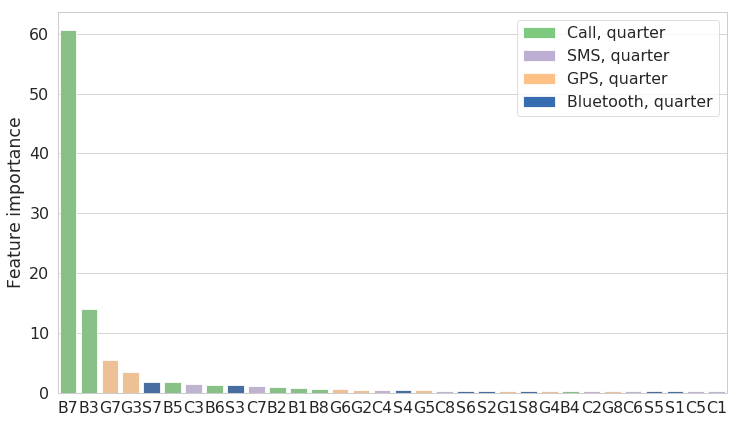

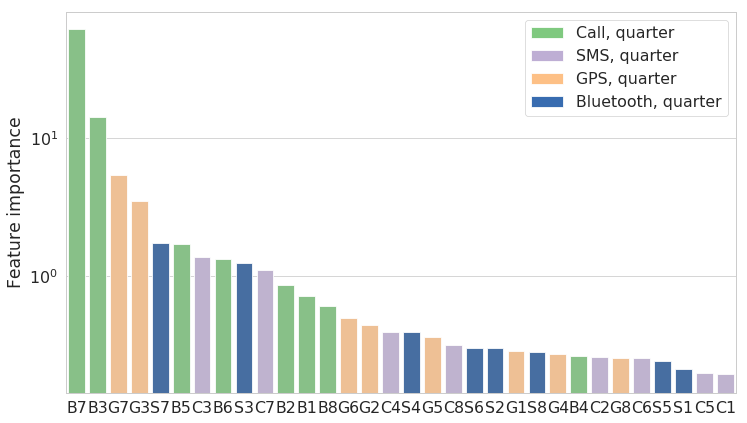

In [280]:
for log_switch in [False, True]:
    fig, ax = plt.subplots()
    bars = sns.barplot(data=fi_agg, y='Feature importance', x=fi_agg.index,
                       hue='cat', dodge=False, ax=ax, log=log_switch)
    custom_lines = [mpl.patches.Patch(facecolor=colorcycle[0]),
                    mpl.patches.Patch(facecolor=colorcycle[1]),
                    mpl.patches.Patch(facecolor=colorcycle[2]),
                    mpl.patches.Patch(facecolor=colorcycle[3])]
    ax.legend(custom_lines, ["Call, quarter", "SMS, quarter", "GPS, quarter",
                             "Bluetooth, quarter"], loc="upper right")
    ax.set_xticklabels(el.get_text().upper() for el in ax.get_xticklabels());
    if log_switch:
        fig.savefig('figs/random_forest_important_features_logarithmic.pdf')
    else:
        fig.savefig('figs/random_forest_important_features_linear.pdf')

Text(0,0.5,'Tree')

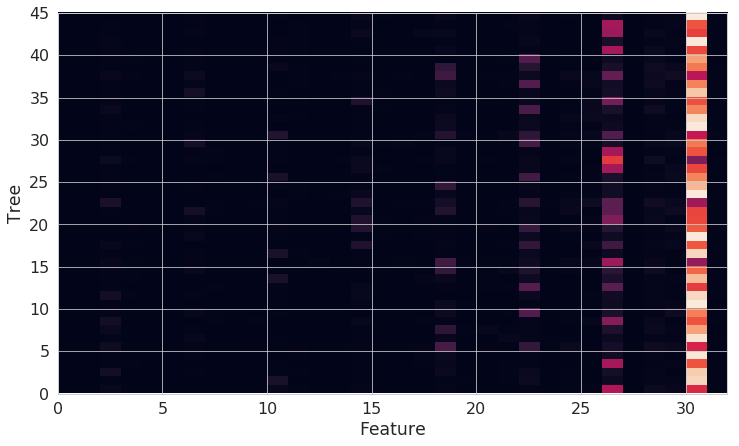

In [286]:
fig, ax = plt.subplots()
ax.pcolorfast(feature_importance)
ax.set_xlabel('Feature')
ax.set_ylabel('Tree')

In [301]:
from sklearn.tree import export_graphviz 
import subprocess

In [336]:
export_graphviz(tr0, out_file='tree.dot') 

In [310]:
tr0.tree_.node_count

31331

In [314]:
n_tree_nodes = np.array([tr.tree_.node_count for tr in est.estimators_])

Text(0,0.5,'# trees')

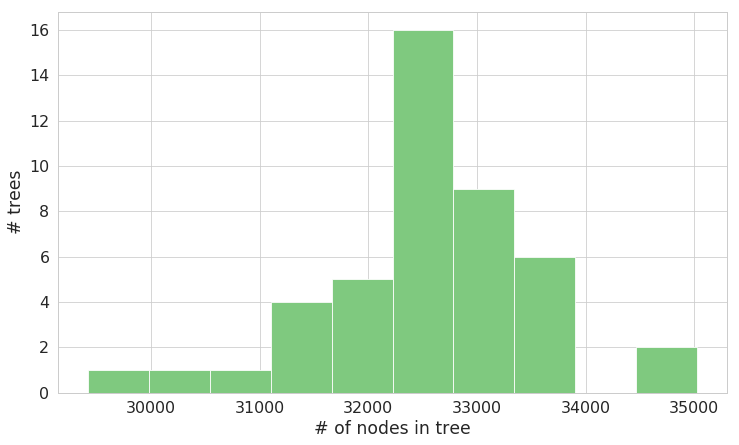

In [319]:
fig, ax = plt.subplots()
ax.hist(n_tree_nodes)
ax.set_xlabel("# of nodes in tree")
ax.set_ylabel("# trees")

In [471]:
kw_rx = re.compile(r'(?P<key>\S+) = (?P<value>.+)')
op_rx = re.compile(r'(?P<key>\S+) (?P<operator>\S=) (?P<value>.+)')

def parse_label(label):
    info = list()
    for el in label.split('\\n'):
        m = kw_rx.match(el)
        if m:
            info.append(m.groupdict())
            continue
        m = op_rx.match(el)
        if m:
            info.append(m.groupdict())
            continue 
    return info 

In [498]:
x_rx = re.compile(r'X\[(\d{1,2})\]')

def parse_label(label):
    m = x_rx.search(label)
    if m:
        return int(m.groups()[0]) 
    return None

In [499]:
nodes, edges = list(), list() 

with open("tree.dot") as fid:
    for line in fid:
        try:
            if 'label' in line:
                start = line.find('"') + 1
                end = line.find('"', start)
                lbl = line[start:end]
                nodes.append((int(line.split(' ', maxsplit=1)[0]),
                              parse_label(lbl)))
                continue
            elif '->' in line:
                a, b = line.replace(' ;', '').split(' -> ')
                edges.append((int(a), int(b)))
        except:
            print(line)

In [500]:
g = nx.DiGraph() 

for nid, attr in nodes:
    g.add_node(nid, nodeattr=attr) 
g.add_edges_from(edges)

In [501]:
nodes[:20]

[(0, 26),
 (1, 28),
 (2, 2),
 (3, 10),
 (4, 29),
 (5, 14),
 (6, 18),
 (7, 25),
 (8, 11),
 (9, 8),
 (10, 23),
 (11, 9),
 (12, 30),
 (13, 20),
 (14, 13),
 (15, 24),
 (16, None),
 (17, None),
 (18, 21),
 (19, None)]

In [474]:
# nx.connectivity.average_node_connectivity(g)

In [475]:
# gi = graph.networkx2igraph(g)

In [476]:
# hst = gi.degree_distribution()

In [477]:
# hst.mean

1.9999361654591084

In [478]:
# hst.sd

0.9999999979625106

In [479]:
# odeg = gi.outdegree() 

# pd.value_counts(odeg)

0    15666
2    15665
dtype: int64

In [480]:
# ideg = gi.indegree()
# pd.value_counts(ideg)

1    31330
0        1
dtype: int64

In [481]:
# np.where(np.array(g.in_degree)[:, 1] == 0)

(array([0]),)

In [502]:
g.nodes[0] 

{'nodeattr': 26}

In [503]:
g.nodes[1]

{'nodeattr': 28}

In [504]:
g.nodes[16802]

{'nodeattr': 31}

In [505]:
nx.shortest_path_length(g, 0, 1)

1

In [506]:
narr = np.array(nodes)

In [507]:
pd.value_counts(narr[:, 1])

17    726
5     717
9     717
1     700
13    677
21    651
25    630
3     584
16    572
18    571
22    555
0     528
19    520
8     519
11    512
4     508
24    507
12    482
29    475
20    457
10    444
7     429
15    424
6     422
14    401
30    392
27    384
23    375
2     363
31    217
28    205
26      1
dtype: int64

In [ ]:
dot_file = export_graphviz(tr0, out_file=None) 